In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer
import torch

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained("/nlp/scr/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

train_dataset = load_from_disk("./data/city_train")
test_dataset = load_from_disk("./data/city_test")

test_dataset = [d for d in test_dataset if d["attribute_type"] == "causal"]
train_dataset = [d for d in train_dataset if d["attribute_type"] == "causal"]

from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/nlp/scr/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=False,
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.interpretor.eval()

model_vectors = dict()
model_labels = dict()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from sklearn.decomposition import PCA

collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True)
dataloader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False)

hypernetwork.interpretor.eval()

model_name = ["HyperDAS-All-Domain", "HyperDAS-City"]
model_path = ["/nlp/scr/sjd24/HyperDAS/RAVEL-Full", "/nlp/scr/sjd24/HyperDAS/city/final_model"]

for name, path in zip(model_name, model_path):
    
    
    hypernetwork.load_model(path)
    
    print(f"Processing {name}")
    hypernetwork.interpretor.das_module.save_rv = True
    hypernetwork.interpretor.das_module.rvs = []
    
    test_loss = []
    correct_idxs = []
    is_causal = []
    attributes = []
    
    curr_idx = 0

    with torch.no_grad():
        for batch_id, batch in enumerate(dataloader):
            
            example_idxs = range(curr_idx, curr_idx + len(batch["editor_input_ids"]))
            curr_idx += len(batch["editor_input_ids"])
            
            if curr_idx >= len(train_dataset):
                break
            
            corresponding_attribute = [test_dataset[i]["attribute"] for i in example_idxs]
            attributes.extend(corresponding_attribute)
            
            intervention_weight=None
                                            
            predictions = hypernetwork.forward(
                editor_input_ids=batch["editor_input_ids"].to("cuda"),
                base_input_ids=batch["base_input_ids"].to("cuda"),
                base_attention_mask=batch["base_attention_mask"].to("cuda"),
                base_intervention_mask=batch["base_intervention_mask"].to("cuda"),
                source_input_ids=batch["source_input_ids"].to("cuda"),
                source_attention_mask=batch["source_attention_mask"].to("cuda"),
                source_intervention_mask=batch["source_intervention_mask"].to("cuda"),
                labels=batch["labels"].to("cuda"),
                inference_mode=None,
                intervention_weight=intervention_weight
            )
            test_loss.append(predictions["loss"].item())
            
            batch_pred_ids = torch.argmax(predictions["logits"], dim=-1)
            is_causal.extend(batch["is_causal"].cpu().numpy().tolist())
            
            for i, (label, pred_ids) in enumerate(zip(batch["labels"].to("cuda"), batch_pred_ids)):
                label_idx = label != -100
                output_idx = torch.zeros_like(label_idx)
                output_idx[:-1] = label_idx[1:]
                
                label = label[label_idx]
                pred_ids = pred_ids[output_idx]
                            
                is_correct = (torch.sum (label == pred_ids) == torch.numel(label)).item()    
                if is_correct:
                    correct_idxs.append(batch_id * len(batch["labels"]) + i)
                    
    total_causal = sum(is_causal)
    total_isolate = len(is_causal) - total_causal

    correct_causal = sum([is_causal[i] for i in correct_idxs])
    correct_isolate = len(correct_idxs) - correct_causal

    causal_acc = correct_causal / total_causal if total_causal > 0 else 0.0
    isolate_acc = correct_isolate / total_isolate if total_isolate > 0 else 0.0
    disentangle_acc = 0.5 * (causal_acc + isolate_acc)

    accuracies = {
        "causal": causal_acc,
        "isolate": isolate_acc,
        "disentangle": disentangle_acc
    }

    rvs = hypernetwork.interpretor.das_module.rvs
    rvs = torch.concatenate(rvs, dim=0)
    
    rvs = rvs[correct_idxs]
    is_causal = [is_causal[i] for i in correct_idxs]
    attributes = [attributes[i] for i in correct_idxs]
    
    pca = PCA(n_components=3)

    # TypeError: Got unsupported ScalarType BFloat16
    rvs = rvs.float().cpu()

    rvs_pca = pca.fit_transform(rvs)
    
    labels = []
    for i in range(rvs_pca.shape[0]):
        label = attributes[i]
        labels += [label]
        
    
    model_vectors[name] = rvs_pca
    model_labels[name] = labels
    

/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.interpretor.hypernetwork.load_state_dict

Processing HyperDAS-All-Domain


/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.interpretor.hypernetwork.load_state_dict

Processing HyperDAS-City


Bbox(x0=0.6468636363636362, y0=0.10999999999999999, x1=0.8008636363636362, y1=0.88)


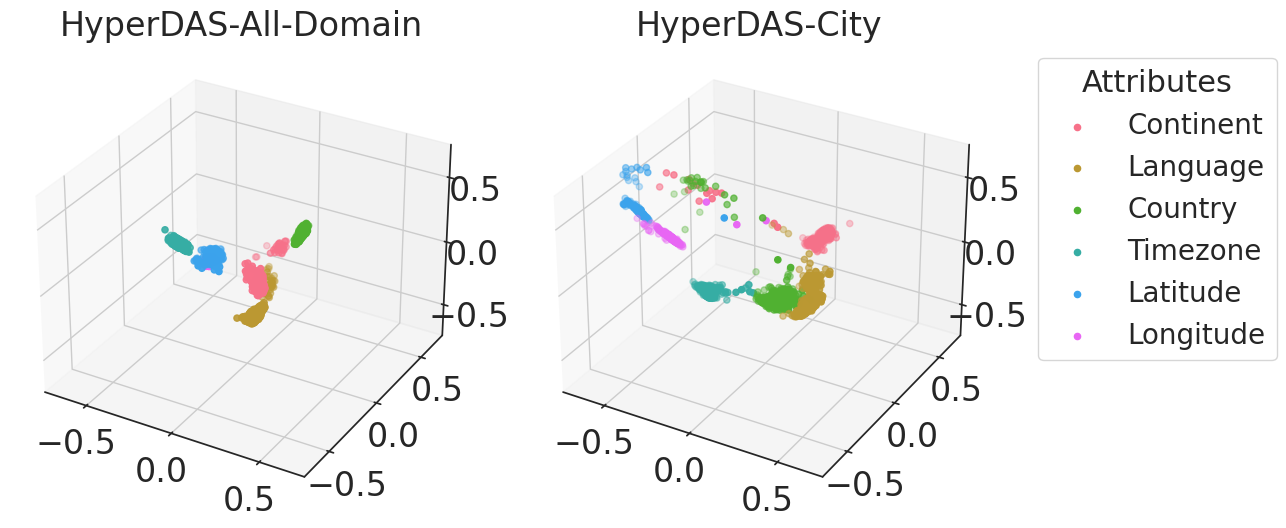

In [82]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

sns.set(style='white')

fig = plt.figure(figsize=(30, 6))

for i, dataset_name in enumerate(model_vectors.keys()):
    # Make axes[i] a 3D plot
    
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    
    labels = model_labels[dataset_name]
    rvs_pca = model_vectors[dataset_name]

    all_available_labels = list(set(labels))
    all_available_colors = sns.color_palette("husl", len(all_available_labels))
    colors = {label: color for label, color in zip(all_available_labels, all_available_colors)}

    # Initialize an empty dictionary to store coordinates by label
    grouped = {label: [] for label in colors.keys()}

    # Group coordinates by labels
    for j in range(rvs_pca.shape[0]):
        x, y, z = rvs_pca[j]
        label = labels[j]
        grouped[label].append((x, y, z))

    # Plot each group with its associated color and add to legend
    for label, coordinates in grouped.items():
        xs, ys, zs = zip(*coordinates)  # Unzip the list of tuples
        ax.scatter(xs, ys, zs, color=colors[label], label=label)
    
    ax.set_xlim(-0.75, 0.75)
    ax.set_ylim(-0.75, 0.75)
    ax.set_zlim(-0.75, 0.75)
    
    ax.set_title(dataset_name, fontsize=24)
    
    if i == 1:
        ax.legend(title="Attributes", fontsize=20, title_fontsize=22, loc='upper right', bbox_to_anchor=(1.65, 1)) # Put the legend inside the plot on the upper right corner
        
        # move ax to the left, next to the first plot
        pos = ax.get_position()
        print(pos)
        pos.x0 = pos.x0 - 0.25
        pos.x1 = pos.x1 - 0.25
        ax.set_position(pos)
        
    # Set x, y, z tick labels to be larger
    ax.tick_params(axis='both', which='major', labelsize=24)
    # plt.subplots_adjust(left=0.1, right=0.9, top=0.99, bottom=0.05)


fig.savefig("hyperdas_pca_comparison.pdf")
    
plt.show()

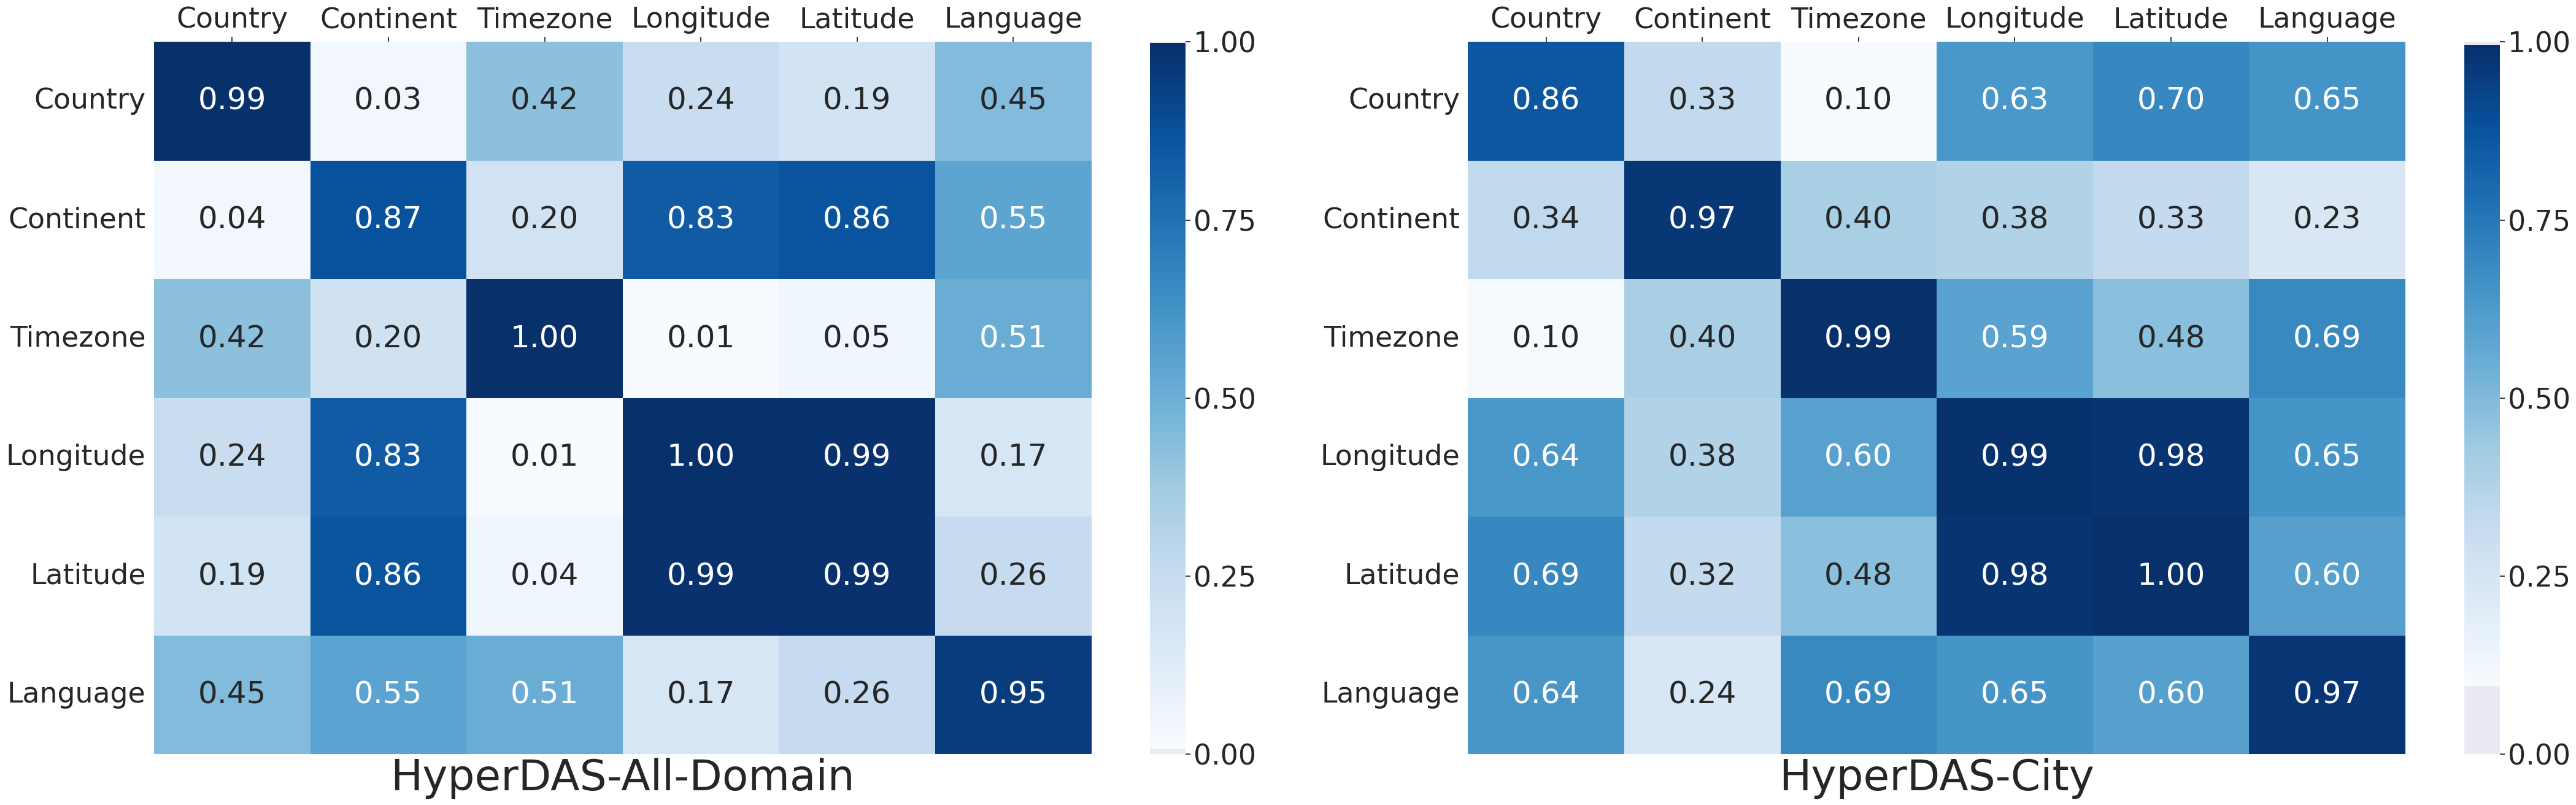

In [ ]:
import random
from torch.nn.functional import cosine_similarity


fig, axes = plt.subplots(1, 2, figsize=(44, 14))

sns.set(font_scale=3)
n_samples = 10000
classes = ['Country', 'Continent', 'Timezone', 'Longitude', 'Latitude', 'Language']
n_classes = len(['Country', 'Continent', 'Timezone', 'Longitude', 'Latitude', 'Language'])

for n, name in enumerate(model_vectors.keys()):
    
    vectors = model_vectors[name]
    labels = model_labels[name]
    
    classes = ['Country', 'Continent', 'Timezone', 'Longitude', 'Latitude', 'Language']
    

    vector_dict = {}

    for label in classes:
        label_idxs = [x for x in range(len(labels)) if labels[x] == label]
        vector_dict[label] = vectors[label_idxs]
    
    cosine_similarities = torch.zeros((n_classes, n_classes))
    for i, (label1, vectors1) in enumerate(vector_dict.items()):
        for j, (label2, vectors2) in enumerate(vector_dict.items()): 
                        
            idx1 = [random.randint(0, vectors1.shape[0] - 1) for _ in range(n_samples)]
            idx2 = [random.randint(0, vectors2.shape[0] - 1) for _ in range(n_samples)]
            
            mat1 = torch.Tensor(vectors1[idx1]).to("cuda")
            mat2 = torch.Tensor(vectors2[idx2]).to("cuda")
            
            sim = cosine_similarity(mat1, mat2, dim=-1)
            sim = torch.mean(sim)
            cosine_similarities[i, j] = abs(sim)

    # use dark blue to light blue for high to low similarity
    sns.heatmap(cosine_similarities, annot=True, cmap="Blues", xticklabels=vector_dict.keys(), yticklabels=vector_dict.keys(), ax=axes[n], fmt=".2f")
    
    # Set the cbar ranging from 0 to 1
    cbar = axes[n].collections[0].colorbar
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])

    
    # plt.title("Cosine Similarity between Reflection Vectors")

    
    # Set heatmap annotation to be larger
    for text in axes[n].texts:
        text.set_fontsize(36)
        
    # Set x, y tick labels to be larger
    ax.tick_params(axis='both', which='major', labelsize=30)

    # Move the x-axis to the top
    axes[n].xaxis.tick_top()
    axes[n].set_xlabel(name, fontsize=50)
    
    
fig.tight_layout()
fig.savefig("hyperdas_cosine_similarity_comparison.pdf")
    


    
    